<blockquote><h2><b>Abstract</b></h2></blockquote>

This project is based on finding information on well productivity and reservoir performance by using reservoir pressures. In exercise 1, using Python, analytical and numerical solutions were evaluated at steady state using lazy and not so lazy methods. In the next exercise, we introduced a time factor to the diffusivity equation and once more evaluate the reservoir pressures using an implicit technique to capture how pressure varies over time. In the next exercise, we introduce three different matrix solvers (Dense, Sparse, and Thomas algorithm) and compare the numerical solver implementation with the line-source solution. In the last exercise, we matched well test data from the provided file with our estimations that we created through simulation. To manually match our numerical model to the well test data we modified initial pressure and permeability values. Furthermore, we plotted the experimental well test data, numerical well pressure solution and corresponding line source solution. In conclusion, we were able to avoid reservoir compaction by observing how well and reservoir performance change over time.

<blockquote><h2><b>Introduction</b></h2></blockquote>

 A well test is a set of procedures, performed under specified conditions, to measure the factors affecting the capability of a well for production[1]. It is helpful to find the size of the large reservoirs and also investigates the end boundaries of the reservoirs. Well testing provides the estimate of permeability under any condition and also provides the near-wellbore condition. It plays a central role in oil and gas industries.  
   
 The diffusivity equation is used to solve the flow problems in porous media [2]. To obtain a solution to the radial flow diffusivity equation it is necessary to specify an initial condition and impose two boundary conditions (Lazy and Not so Lazy). The initial condition simply states that the reservoir is at a uniform pressure pi when production begins [1]. Ultimately, evaluated the reservoir behaviour from well and reservoir pressures and its dependence on time. To monitor changes in reservoir permeability, a key tool is well pressure testing.[3]

 Dense, sparse and thomas matrix solvers are used to find the numerical solution, each of them have different properties and efficiencies. Matching the simulated results with the provided well data shows that pressure decreases and becomes constant at the end giving a signal that the pressure wave has reached at the end of the reservoir.

<table>
    <tr>
        <td>Libraries</td>
    </tr>
</table>

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import math as m
import scipy as sp
import pandas as pd

In [2]:
# The Pressure solver class contains all the functions required in the project
# After initializing the class for each excercise the implementation is shown.
class PressureSolver:
    """
    A finite difference solver to solve pressure distribution in
    a reservoir, logarithmic grid has been used, y = ln(r/rw)
    The solver uses SI units internally, while "practical field units"
    are required as input.
    Input arguments:
    name symbol unit
    --------------------------------------------------------------
    Number of grid points N dimensionless
    Constant time step dt days
    Well radius rw ft
    Outer reservoir boundary re ft
    Height of reservoir h ft
    Absolute permeability k mD
    Porosity phi dimensionless
    Fluid viscosity mu mPas (cP)
    Total (rock+fluid) compressibility ct 1 / psi
    Constant flow rate at well Q bbl / day
    Initial reservoir pressure pi psi
    -------------------------------------------------------------
    """
    def __init__(self, N, dt, T, rw=0.318, re=1000.0, h=11.0, phi=0.25, mu=1.0, ct=7.8e-6, Q=1000.0, k=500, pi=3900.0):
    # Unit conversion factors (input units --> SI)
        self.ft_to_m_ = 0.3048
        self.psi_to_pa_ = 6894.75729
        self.day_to_sec_ = 24.*60.*60.
        self.bbl_to_m3_ = 0.1589873
        # Grid
        self.N_ = N
        self.rw_ = rw*self.ft_to_m_
        self.re_ = re*self.ft_to_m_
        self.h_ = h*self.ft_to_m_
        # Rock and fluid properties
        self.k_ = k*1e-15 / 1.01325
        self.phi_ = phi
        self.mu_ = mu*1e-3
        self.ct_ = ct / self.psi_to_pa_
        # Initial and boundary conditions
        self.Q_ = Q*self.bbl_to_m3_ / self.day_to_sec_
        self.pi_ = pi*self.psi_to_pa_
        # Time control for simulation
        self.dt_ = dt*self.day_to_sec_
        self.T_ = T*self.day_to_sec_
        self.time = np.arange(0, self.T_ + self.dt_, self.dt_)

        self.alpha =  self.Q_*self.mu_/(2*np.pi*self.h_*self.k_)
        self.ye = np.log(self.re_/self.rw_)

        #Defining delta y and y, depending if N is an arrray or not
        if isinstance(self.N_, np.ndarray):
            self.dy = 0 # Is redefined accurately for an array in the error function
            self.y = 0  # Is redefined accurately for an array in the error function
        else:
            self.dy = (self.ye)/self.N_
            self.y = np.array([self.dy/2 + i*self.dy for i in range(self.N_)])
            self.y = np.append(self.y, self.ye) # Appending so that the last value is always the edge of the reservoir.
        
        #Defining hydraulic diffusivity
        self.eta = self.k_/(self.mu_*self.phi_*self.ct_)

        self.Xi = (self.eta*np.exp(-2*self.y)*self.dt_)/((self.rw_**2)*self.dy**2)
        self.beta = (self.Q_*self.mu_*self.dy)/(2*np.pi*self.k_*self.h_)
        self.r = self.rw_ * np.exp(self.y)
        
# Excercise 1: Steady State Solution

    def Mat_A(self):
        '''
        Making matrix A for the steady state solution A.x = B
        '''
        a = c = np.ones(self.N_ - 1) #Initiating lower and upper diagnals
        b = np.repeat(-2, self.N_) #Initiating main diagnal
        b[0] = -1
        A = np.diag(a, k=-1) + np.diag(b, k = 0)+np.diag(c, k =1)
        return A

    def Mat_B(self):
        '''
        Making matrix B for the steady state solution A.x = B
        '''
        B = np.zeros(self.N_)
        B[0] = self.alpha*self.dy
        return B

    def numerical_lazy(self):
        '''
        Solving the steady state solution with the lazy method.
        The function changes the values within the matrix B as needed.
        '''
        A = self.Mat_A()
        B = self.Mat_B()
        B[-1] = -1*self.pi_
        sol = np.linalg.solve(A, B)
        sol = np.append(sol, self.pi_) #Appending the last value to be the pressure at the edge of the reservoir
        return self.y, sol

    def numerical_notlazy(self):
        '''
        Solving the steady state solution with the Not so lazy method.
        The function changes the values within the matrices A and B as needed.
        '''
        A = self.Mat_A()
        A[-1, -1] = -3
        B = self.Mat_B()
        B[-1] = -2*self.pi_
        sol = np.linalg.solve(A, B)
        sol = np.append(sol, self.pi_) #Appending the last value to be the pressure at the edge of the reservoir
        return self.y, sol
       

    def analytical(self, y):
        '''
        Analytical Solver for the steady state solution
        '''
        if y == 0: # To compare the results if we have a single node for excercise 1 part 5; initiates an array of y on its own
            y = np.linspace(self.dy / 2, self.ye, 200)
        sol = self.pi_ + self.alpha*(y - self.ye)
        return y, sol

    def err(self):
        '''
        The function works for self.N_ as an array of different grid numbers.
        For each grid size the solver calculates the numerical solution for both the Lazy and Not so Lazy method
        and finds the error by subtracting it from the analytical solution
        
        To always select the same point in space physically, it selects the centre node within the given grid size
        The function then plots the errors.
        '''
        M = self.N_
        # Initializing arrays that store the error for each grid size
        err1 = []
        err2 = []
        for x in M:
            self.N_ = int(x)
            # dy and y needs to be reinitialized because the input was an array for N, so it initializes it for each grid size.
            
            self.dy = self.ye/self.N_
            self.y = np.array([self.dy/2 + i*self.dy for i in range(self.N_)])
            _, sol1 = self.numerical_lazy()
            _, sol2 = self.numerical_notlazy()
            
            i = round(int(x)/2) # Ensure always center point is chosen to calculate error
            _, sol3 = self.analytical(self.y[i]) #Calculating analytical solution at center point
            err1.append(np.abs(sol3 - sol1[i])) #error with Lazy method
            err2.append(np.abs(sol3 - sol2[i])) #error with Not-Lazy method
        plt.plot(M, err1, 'g-', label = "Lazy Sol. error")
        plt.plot(M, err2, 'b.', label = "Not Lazy Sol. error")
        plt.legend()
        plt.grid()
        plt.xlabel('log(Number of grid points (N))')
        plt.ylabel('log(Numerical Error)')
        plt.xscale('log')
        plt.yscale('log')

# Excercise 2 & 3: Time Dependent Solution

    def time_dep_mat(self, method):
        '''
        The function creates the matrix A and D for the time dependent solution
        For each of the matrix method: dense, sparse and thomas, the function 
        initializes the matrices as required
        '''
        a = self.Xi[1:self.N_] * -1 #lower diagonal
        c = self.Xi[:self.N_-1]*-1 #upper diagonal
        b = 1+2*self.Xi[:self.N_] #main diagonal
        b[0] = 1 + self.Xi[0]
        b[-1] = 1+3*self.Xi[-2] #since we have appended ye at end of array of y, we get length of Xi one more than the total grid size.
        D = np.zeros(self.N_)
        D[0] = -1 * self.beta* self.Xi[0]
        D[-1] = 2*self.pi_*self.Xi[-2]
        if method == 's':
            self.diagonals=np.zeros((3,self.N_))
            self.diagonals[1,:]  = b
            self.diagonals[2,1:] = c
            self.diagonals[0,:-1]= a
            A = sp.sparse.spdiags(self.diagonals, [-1,0,1], self.N_, self.N_,format='csc')
            return A, D
        elif method == 'd':
            A = np.diag(a, k=-1) + np.diag(b, k = 0)+np.diag(c, k =1)
            return A, D
        elif method == 't':
            return a, b, c, D

    def time_step(self, Pold, method):
        '''
        Solves for a single time step for the time dependent solution, for dense and sparse matrix solvers
        '''
        A, D = self.time_dep_mat(method)
        rhs = Pold + D
        if method == 's':
            return sp.sparse.linalg.spsolve(A, rhs)

        elif method == 'd':    
            return np.linalg.solve(A, rhs)
    
    def time_solver(self, method):
        '''
        Solves for each matrix solver method for the given total time.
        '''
        Pold = np.repeat(self.pi_, self.N_)
        if method == 't':
            l, d, u, z = self.time_dep_mat(method) #Gets the diagnals and Matrix D for the thomas matrix solver
            return self.r, self.thomas_algorithm(l, d, u, Pold+z)
        else:
            self.Po = [Pold[0]]
            t = 0
            while t< self.T_:
                Pnew = self.time_step(Pold, method)
                Pold = Pnew
                self.Po.append(Pold[0]) # Collecting Po values for each time step
                t+= self.dt_
            Pnew = np.append(Pnew, Pnew[-1]) #Appends to get the same dimensions as r
            return self.r, Pnew
        

    def thomas_algorithm(self, l, d, u, r):
        """
            Solves a tridiagonal linear system of equations with the Thomas-algorithm.
            The code is based on pseudo-code from the following reference:
            Cheney, E. W., & Kincaid, D. R.
            Numerical mathematics and computing, 7th edition,
            Cengage Learning, 2013.
            IMPORTANT NOTES:
            - This function modifies the contents of the input vectors l, d, u and rhs.
            - For Numba to work properly, we must input NumPy arrays, and not lists.
            :param l: A NumPy array containing the lower diagonal (l[0] is not used).
            :param d: A NumPy array containing the main diagonal.
            :param u: A NumPy array containing the upper diagonal (u[-1] is not used).
            :param r: A NumPy array containing the system right-hand side vector.
            :return: A NumPy array containing the solution vector.
        """
        # Allocate memory for solution
        solution = np.zeros_like(d)
        n = len(solution)
        # Dummy values added because the upper and lower diagnals already have length N-1
        u = np.append(u, 0)
        l = np.insert(l,0, 0)
        # Forward elimination
        for k in range(1, n):
            xmult = l[k] / d[k-1]
            d[k] = d[k] - xmult*u[k-1]
            r[k] = r[k] - xmult*r[k-1]
        # Back-substitution
        solution[n-1] = r[n-1] / d[n-1]
        for k in range(n-2, -1, -1):
            solution[k] = (r[k]-u[k]*solution[k+1])/d[k]
        #print(self.r)
        solution = np.append(solution, self.pi_)
        return solution
    
    def line_source(self):
        self.lsol = []
        for tm in self.time:
            if tm == 0:
                tm = 0.00001 #To prevent denominator to become zero at time = 0
            u = -1*self.r**2/(4*self.eta*(tm))
            W = sp.special.expi(u)
            Y = ((self.Q_*self.mu_)/(4 * np.pi * self.k_ * self.h_))*W
            l_source_sol = self.pi_ + Y
            self.lsol.append(l_source_sol[0]) #Collecting Po values for each time step
            tm+= 1
        return self.r, l_source_sol

# Exercise 4: Matching Numercial Solution with well test data.

    def well_pressure(self):
        '''To calculate well pressure as a function of well-block pressure
        '''
        # To get Po values for the numerical and line source solution.
        yy = self.time_solver('s')
        xx = self.line_source()

        Pw = np.asarray(self.Po) - ((self.Q_*self.mu_*self.dy)/(4 * np.pi*self.h_* self.k_))
        return self.time, Pw, np.asarray(self.lsol)

    def plot_graph(self,x_coord, y_coord, styl = '-', lbl = 'Label',xlabel = 'xlabel', ylabel = 'ylabel', title = 'title'):
        plt.plot(x_coord, y_coord, styl, label = lbl)
        plt.legend()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid()
        plt.title(title)

    def read_well_data(self):
        '''Read well data into a data frame
        '''
        url  = 'https://raw.githubusercontent.com/ahiorth/CompEngineering/master/projects/H22/project2/data/well_bhp.dat'
        well_data = pd.read_csv(url, delim_whitespace='True')
        well_data["time"] = well_data['time']*3600 #Converts time from hours to seconds
        well_data['well_pressure'] = well_data['well_pressure']*6894.75729 #Converts pressure from psi to Pa
        return well_data

    
    def curve_fit(self):
        '''
        Curve fit function to find the best possible values for dy and k, since these variables are present in the well pressure
         formula.
         The idea was to then find the re from the best fit value of dy, however the function didnot give reasonable values,
         therefore, curve fitting was done manually in an iterative process
         '''
        yy = self.time_solver('s')
        Po = np.asarray(self.Po)
        a_guess = self.dy
        b_guess = self.k_
        def Pw(Po, a, b):
            return Po - ((self.Q_*self.mu_*a)/(4 * np.pi*self.h_* b))
        
        wd  = self.read_well_data()
        t = wd["time"].values
        wp = wd["well_pressure"].values
        c, cov = sp.optimize.curve_fit(Pw, t, wp, p0=[a_guess, b_guess])
        return c
      
    def Volume_of_water(self):
        '''Calculate volume of water for the given value of re'''
        V = np.pi*(self.re_**2)*self.h_ *self.phi_
        return V, self.re_ #porosity factor is added because of the rocks under the surface of earth

## Excercise 1: Steady state Solution

### Part 5

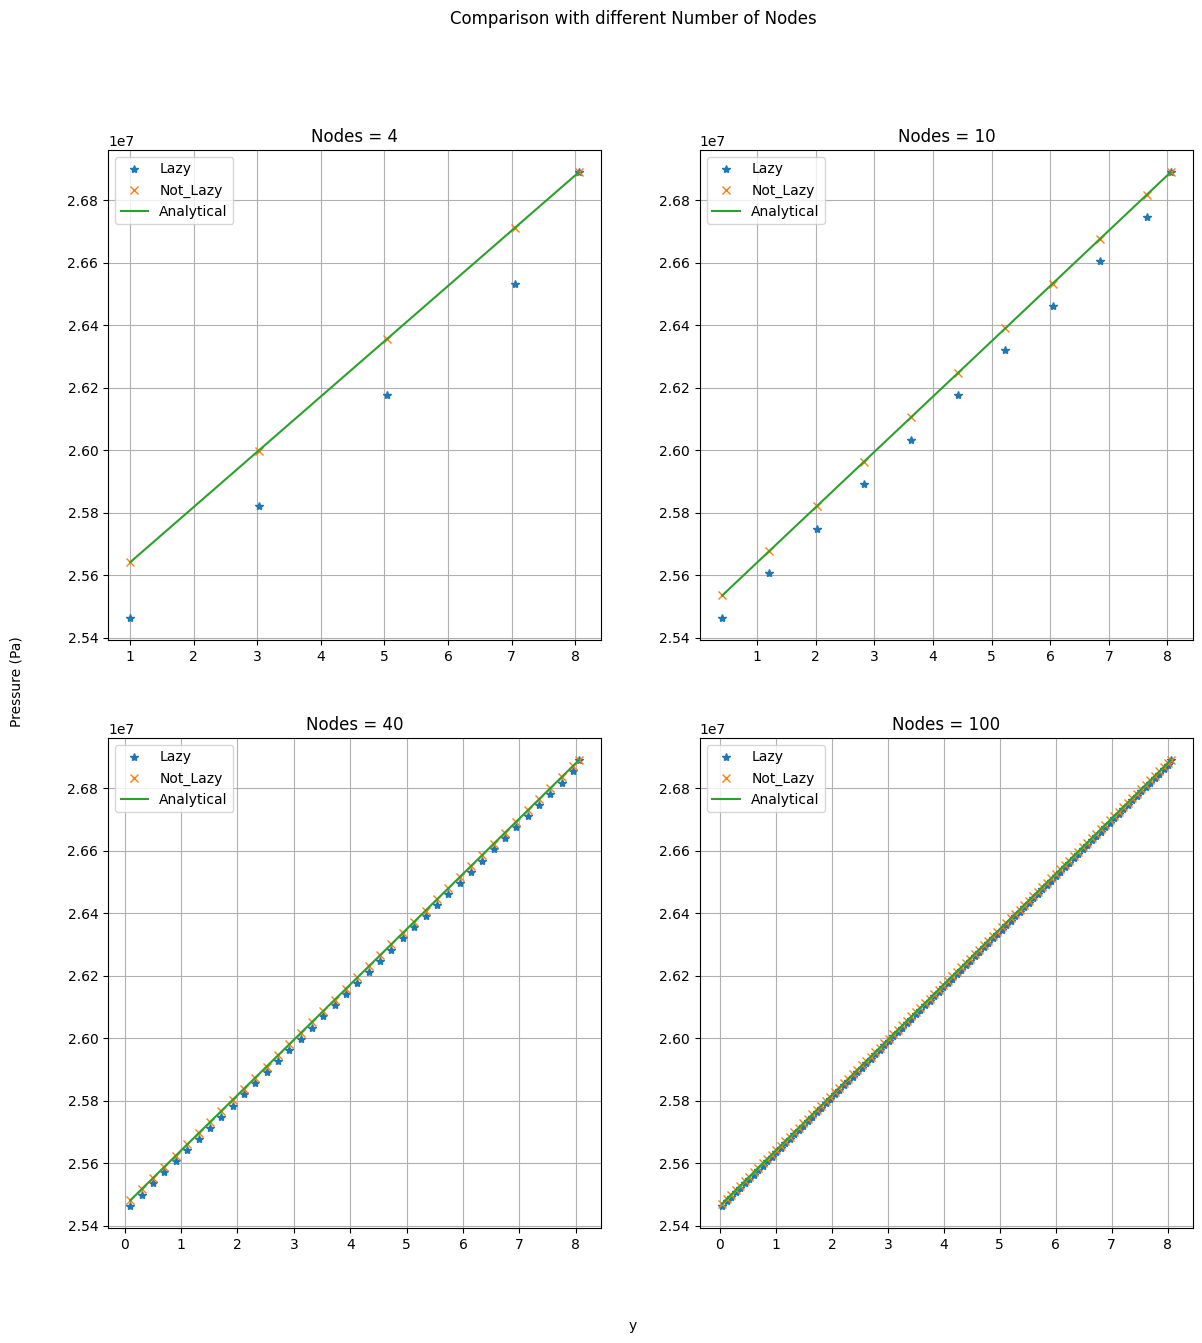

In [3]:
N = [4, 10, 40, 100]
fig, axs = plt.subplots(2,2, figsize = (14,14))
fig.suptitle('Comparison with different Number of Nodes')
fig.text(0.5, 0.04, 'y', ha='center', va='center')
fig.text(0.06, 0.5, 'Pressure (Pa)', ha='center', va='center', rotation='vertical')
# Making subplots for different step sizes
i = 0
while i < len(N):
    PS = PressureSolver(N[i], 0.01, 1)
    y, sol = PS.numerical_lazy()
    y1, sol1 = PS.numerical_notlazy()
    y2, sol2 = PS.analytical(0)
    l = 1 if i >=2 else 0
    m = 1 if i == 1 or i == 3 else 0
    axs[l, m].plot(y,sol, '*', label = 'Lazy')
    axs[l, m].plot(y1, sol1, 'x', label = 'Not_Lazy')
    axs[l, m].plot(y2, sol2, label = 'Analytical')
    axs[l, m].set_title('Nodes = {}'.format(N[i]))
    axs[l, m].legend()
    axs[l, m].grid()
    i+= 1

C:\Users\gikom\AppData\Local\Temp\ipykernel_13128\21853273.py:64: RuntimeWarning: divide by zero encountered in double_scalars
  self.Xi = (self.eta*np.exp(-2*self.y)*self.dt_)/((self.rw_**2)*self.dy**2)


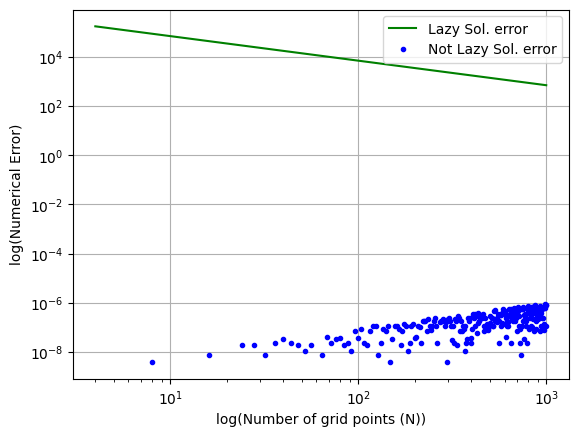

In [4]:
#Scatter plot for range of step sizes against numerical error
N = np.linspace(4,1000, 250)
PS = PressureSolver(N,0.01, 1)
PS.err()

### Discussion for Excercise 1:

The numerical error scales as expected witth respect to the grid size. Changing the grid size with a factor of 10, reduces the numerical error with the same factor, for the Lazy numerical Method, as proved theoratically in part 4 of Excercise 1

However for Not_Lazy method the error is very low, but it can be seen that it increases as we increase the grid size

## Exercise 2: Time Dependent Solution

### Part 2

In [5]:
PS = PressureSolver(4, 0.01, 10)
Matrix_A,_ = PS.time_dep_mat('d')
print("Matrix A: \n", Matrix_A)

Matrix A: 
 [[ 5.28702460e+03 -5.28602460e+03  0.00000000e+00  0.00000000e+00]
 [-9.42633218e+01  1.89526644e+02 -9.42633218e+01  0.00000000e+00]
 [ 0.00000000e+00 -1.68095582e+00  4.36191165e+00 -1.68095582e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.99757363e-02  1.08992721e+00]]


### Part 3

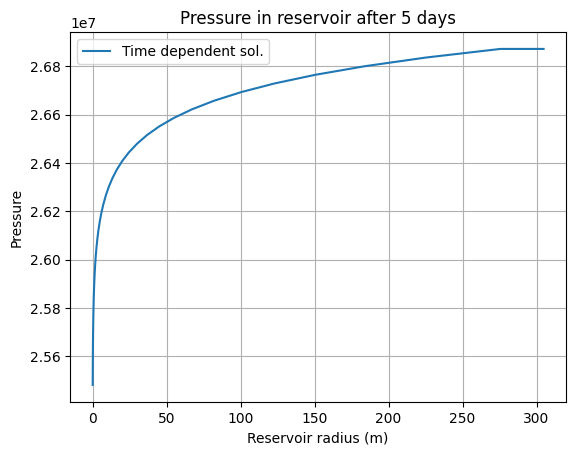

In [6]:
method = 's' #Using sparse matrix solver
Nodes = 40
total_time = 5 #time in days
PS = PressureSolver(Nodes, 0.01, total_time)
radius, pressure = PS.time_solver(method)
PS.plot_graph(radius, pressure, '-', 'Time dependent sol.', 'Reservoir radius (m)', 'Pressure', "Pressure in reservoir after {} days".format(total_time))

## Exercise 3: Accuracy and Performance of Time Dependent Solution

### Part 1

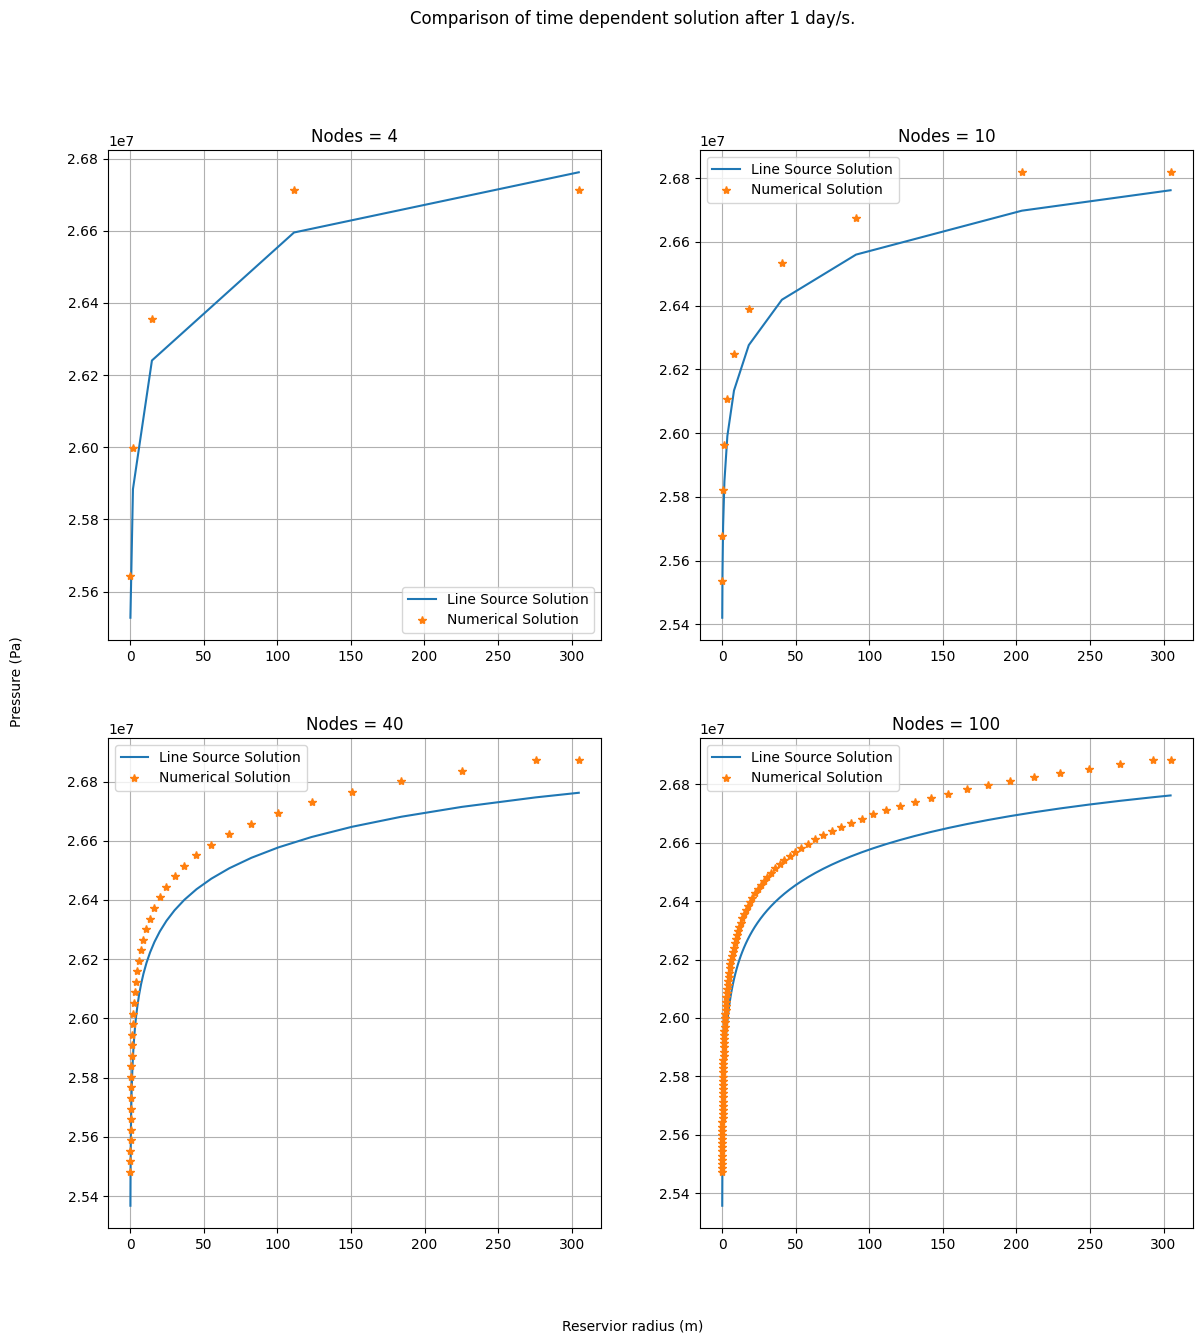

In [7]:
N = [4, 10, 40, 100]
method = 's'
total_time = 1
fig, axs = plt.subplots(2,2, figsize = (14,14))
fig.suptitle('Comparison of time dependent solution after {} day/s.'.format(total_time))
fig.text(0.5, 0.04, 'Reservior radius (m)', ha='center', va='center')
fig.text(0.06, 0.5, 'Pressure (Pa)', ha='center', va='center', rotation='vertical')
i = 0
# Making subplots for different step sizes and comparing results with line source solution
while i < len(N):
    PS = PressureSolver(N[i], 0.01, total_time)
    r, p = PS.line_source()
    r1, p1 = PS.time_solver(method)
    l = 1 if i >=2 else 0
    m = 1 if i == 1 or i == 3 else 0
    axs[l, m].plot(r,p, '-', label = 'Line Source Solution')
    axs[l, m].plot(r1, p1, '*', label = 'Numerical Solution')
    axs[l, m].set_title('Nodes = {}'.format(N[i]))
    axs[l, m].legend()
    axs[l, m].grid()
    i+= 1

### Part 1 Discussion:

When comparing the numerical solution with the line source solution the error reduces by increasing the number of grid points. However, a more notable point was that the total duration also effects the error between the line source and numerical solution, substantially. 

Another observation was that the error increases as we go from the start of the reservoir to the end, for each node size.

### Part 2

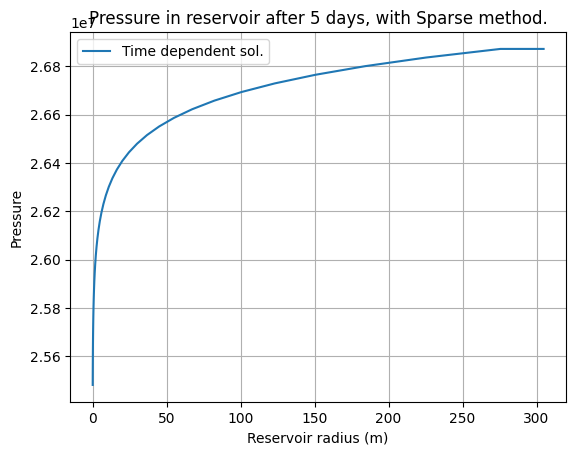

In [8]:
#Input the solver matrix method
#To solve for given solver method
method = input("Please input 'd', for dense matrix, 's', for sparse matrix and 't', for thomas algorithm. ")
Nodes = 40
total_time = 5
PS = PressureSolver(Nodes, 0.01, total_time)
radius, pressure = PS.time_solver(method)
m = 'Dense' if method == 'd' else 'Sparse' if method == 's' else 'Thomas_alg'

PS.plot_graph(radius, pressure, '-', 'Time dependent sol.', 'Reservoir radius (m)', 'Pressure', "Pressure in reservoir after {} days, with {} method.".format(total_time, m))

In [9]:
# Solving with different matrix solver methods, to find time for each solver:
m1 = 'd'
m2 = 's'
m3 = 't'
Nodes = 50
total_time = 10
PS = PressureSolver(Nodes, 0.01, total_time)
print("Time to solve with dense matrix for {} nodes and after {} days is: ".format(Nodes, total_time))
%timeit PS.time_solver(m1)
print("\n","Time to solve with sparse matrix for {} nodes and after {} days is: ".format(Nodes, total_time))
%timeit PS.time_solver(m2)
print("\n", "Time to solve with thomas algorithm for {} nodes and after {} days is: ".format(Nodes, total_time))
%timeit PS.time_solver(m3)

Time to solve with dense matrix for 50 nodes and after 10 days is: 
359 ms ± 33.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

 Time to solve with sparse matrix for 50 nodes and after 10 days is: 
288 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

 Time to solve with thomas algorithm for 50 nodes and after 10 days is: 
155 µs ± 1.9 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The dense matrix is the slowest and the thomas algorithm is the fastest matrix solver method.
These results are noticeable if the node size is 50 or greater

## Exercise 4: Match Model to Well Test Data

### Part 2

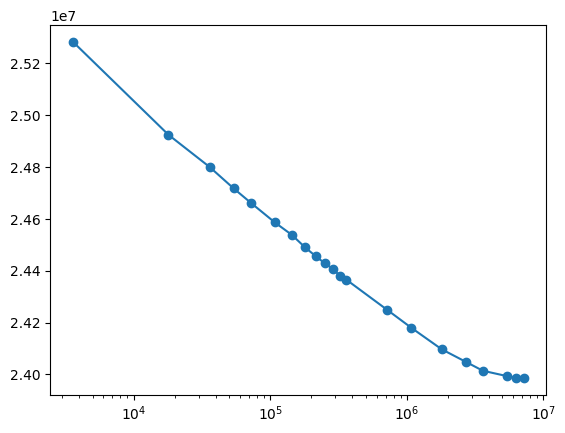

In [10]:
#Plotting experimental well data
wd = PS.read_well_data()
plt.plot(wd["time"],wd["well_pressure"],'o-')
plt.xscale('log')

### Part 3

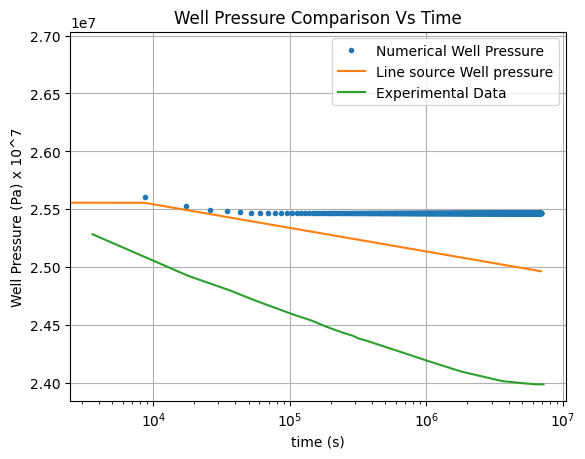

In [11]:
# With initial values of pi, re and k
method = 's'
Nodes = 400
total_time = 80
PS = PressureSolver(Nodes, 0.1, total_time, pi = 3900, k= 500, re= 1000)
time, pressure, l_pressure= PS.well_pressure()
PS.plot_graph(time, pressure, styl= '.', lbl= "Numerical Well Pressure")
PS.plot_graph(time, l_pressure, lbl= "Line source Well pressure")
PS.plot_graph(wd["time"],wd["well_pressure"], lbl= "Experimental Data", xlabel= 'time (s)', ylabel= 'Well Pressure (Pa) x 10^7', title= 'Well Pressure Comparison Vs Time')
plt.xscale('log')

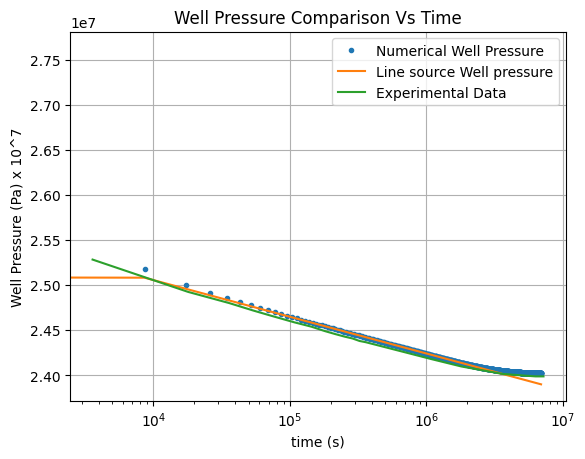

In [12]:
# After iterations the values of pi, k and re were found to be as shown
PS = PressureSolver(Nodes, 0.1, total_time, pi = 4007, k= 250, re= 8500)
time, pressure, l_pressure= PS.well_pressure()
PS.plot_graph(time, pressure, styl= '.', lbl= "Numerical Well Pressure")
PS.plot_graph(time, l_pressure, lbl= "Line source Well pressure")
PS.plot_graph(wd["time"],wd["well_pressure"], lbl= "Experimental Data", xlabel= 'time (s)', ylabel= 'Well Pressure (Pa) x 10^7', title= 'Well Pressure Comparison Vs Time')
plt.xscale('log')

### Discussion:

In the iterative process various combinations of re, k and pi result in a solution close to experimental data. However, the values we chose were the ones that closely replicated the effect of well pressure getting constant at the end.

In [13]:
c = PS.curve_fit()
print(c)

[-2.35502556e+01  4.48364815e-14]


c:\Users\gikom\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


### Part 4

In [14]:
Volume, radius = PS.Volume_of_water()
print('Volume of water based for the reservoir of radius {}m is: {}m^3'.format(radius, Volume))

Volume of water based for the reservoir of radius 2590.8m is: 17675239.448891815m^3


<blockquote><h2><b>References</b></h2></blockquote>

<pre>
[1] Amin Nemati, Introduction to Well Testing
    Link: https://www.academia.edu/43686719/Introduction_to_well_testing_Analysis_By_Amin_Nematizadeh_Haghighi
[2] Drilling Engineering, 2021
    Link: https://www.sciencedirect.com/topics/engineering/diffusivity-equation
[3] Well Test Analysis in Practice, Society of Petroleum Engineers (SPE) 
    Available here: https://jpt.spe.org/twa/well-test-analysis-practice